[Visualizations &lt;](9_Visualizations.ipynb) | [&gt; API Design](11_APIs.ipynb)

# What are users struggling the most with?

Notebook errors are a good indicator of what users struggle with. However, it’s important to keep in mind that many users will take care of errors before posting a notebook publicly to GitHub. It's likely that most struggles faced by users are not visible to us in the end product of their notebook. Here, I investigate the frequency and types of errors as well as the relationship between number of errors and a variety of other factors, including educational status, amount of markdown text, and whether the notebook cells were run in order. 

## Results Summary:
- 11.84% of notebooks have at least one error.
- The most frequent errors are NameError, TypeError, ValueError, and Keyboard Interrupt.
- We are 95% confident that notebooks ran out of order have between 0.21 and 0.49 more errors than notebooks ran in order. 
- The number of errors in a notebook is not associated with the amount of markdown, whether the notebook is educational, whether the notebook uses machine learning frameworks, or whether the notebook's repository is collaborative, in sight, or isolated.
----------

# Import Packages and Load Data

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import math
import matplotlib.pyplot as plt
import pickle

In [2]:
import load_data
import datetime

Load dataframes.

In [3]:
notebooks = load_data.load_notebooks()
repos = load_data.load_repos()

Notebooks loaded in 0:00:35.610074
Repos loaded in 0:00:04.238007


Load aggregated dataframes. Code used to create them is in [aggregate.py](aggregate.py).

In [4]:
errors_df = load_data.load_errors()
cell_order_df = load_data.load_cell_order()
collab_status_df = load_data.load_collab_status()
edu_status_df = load_data.load_edu_status()
nb_imports_df = load_data.load_nb_imports()

Errors loaded in 0:00:10.047949
Cell order loaded in 0:00:41.377326
Collaboration statuses loaded in 0:00:00.080546
Educational status loaded in 0:00:00.029418
Notebook imports loaded in 0:00:53.264711


---
# Manipulate Data

Add number of errors column.

In [5]:
errors_df['num_errors'] = [len(e) for e in errors_df.error_names]

Add machine learning use to errors dataframe if not already there.

In [6]:
start = datetime.datetime.now()
for ml in ['sklearn','tensorflow','keras']:
    if ml not in nb_imports_df.columns:
        nb_imports_df[ml] = [ml in [i[0] for i in im] for im in nb_imports_df.imports]
        print(ml, datetime.datetime.now() - start)
end = datetime.datetime.now()
print(end - start)

sklearn 0:00:04.420792
tensorflow 0:00:08.780150
keras 0:00:13.214183
0:00:13.214666


In [7]:
errors_df = errors_df.merge(
    nb_imports_df[['file','sklearn','tensorflow','keras']], 
    on = 'file'
)

---
# Visualizations and Statistics

## Looking at Number and Types of Errors

In [8]:
percent_error = 100 * sum(errors_df['num_errors'] > 0) / sum(errors_df['count'])
print("Only {0}% of cells have errors.".format(round(percent_error, 2)))

Only 0.41% of cells have errors.


In [9]:
percent_nb_error = 100 * sum(errors_df.num_errors > 0) / len(errors_df)
none = sum(errors_df.num_errors == 0)
at_least_1 = sum(errors_df.num_errors > 0)
at_least_5 = sum(errors_df.num_errors >= 5)

print("{0} notebooks have no errors ({1}%).".format(
    round(none, 2),
    round(100*none/len(errors_df), 2)
))
print("{0} notebooks have at least one error ({1}%).".format(
    round(at_least_1, 2),
    round(100*at_least_1/len(errors_df), 2)
))
print("{0} notebooks have at least five errors ({1}%).".format(
    round(at_least_5, 2),
    round(100*at_least_5/len(errors_df), 2)
))

3782335 notebooks have no errors (88.16%).
508049 notebooks have at least one error (11.84%).
23394 notebooks have at least five errors (0.55%).


Narrow down to notebooks with at least one error.

In [10]:
errors_df = errors_df[errors_df.num_errors > 0]
all_errors = ','.join([','.join([e for e in error]) for error in errors_df.error_names]).split(',')
error_counts = pd.Series(all_errors).value_counts().reset_index().rename(columns = {'index':'error', 0:'count'})

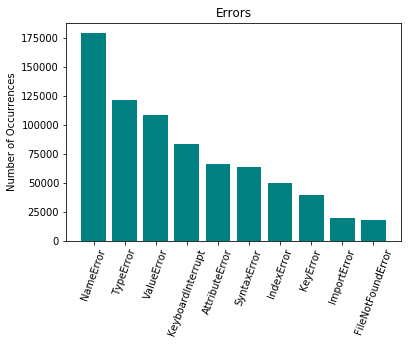

In [11]:
x = error_counts['error'][:10]
x_pos = np.arange(len(x))
y = error_counts['count'][:10]

plt.bar(x_pos, y, color = 'teal')
plt.xticks(x_pos, x, rotation = 70)
plt.title('Errors')
plt.ylabel('Number of Occurrences')
plt.show()

## Are errors more or less common in notebooks run in order?

In [12]:
errors_order_df = errors_df.merge(cell_order_df[['file','in_order']], on = 'file')
in_order = errors_order_df[errors_order_df.in_order == True]
out_order = errors_order_df[errors_order_df.in_order == False]

In [13]:
print("Among notebooks run in order, there is an average of {0} errors per notebook.".format(
    round(in_order.num_errors.mean(), 2)
))
print("Among notebooks run out of order, there is an average of {0} errors per notebook.".format(
    round(out_order.num_errors.mean(), 2)
))

Among notebooks run in order, there is an average of 1.67 errors per notebook.
Among notebooks run out of order, there is an average of 2.02 errors per notebook.


#### Two sample t test for difference in mean number of errors between notebooks run in order and notebooks run out of order.

$H_0$: $µ_{in\_order}$ = $µ_{out\_order}$

$H_0$: $µ_{in\_order}$ ≠ $µ_{out\_order}$

Where $µ_{in\_order}$ is the average number of errors in a notebook run in order, $µ_{out\_order}$ is the average number of errors in a notebook run out of order.

In [14]:
se = (in_order.num_errors.var()/len(in_order) + out_order.num_errors.var()/len(out_order))**0.5
t = (out_order.num_errors.mean() - in_order.num_errors.mean()) / se
df = len(in_order) + len(out_order) - 2
p_value = 1 - st.t.cdf(t,df) if t > 0 else st.t.cdf(t,df)
print("With a t-statistic of {0} and p-vlaue of {1}, we conclude that the average number of errors is different depending on whether a notebook was run in order.".format(
    round(t,2), round(p_value,2)
))

tstar = st.t.ppf(0.975, df)
lower = (out_order.num_errors.mean() - in_order.num_errors.mean()) - tstar*se
upper = (out_order.num_errors.mean() - in_order.num_errors.mean()) + tstar*se
print("\nWe are 95% confident that notebooks run out of order have between {0} and {1} more errors than notebooks run in order.".format(
    round(lower,2), round(upper,2)
))

With a t-statistic of 4.87 and p-vlaue of 0.0, we conclude that the average number of errors is different depending on whether a notebook was run in order.

We are 95% confident that notebooks run out of order have between 0.21 and 0.49 more errors than notebooks run in order.


#### Are there different types of errors common between notebooks run in order and notebooks run out of order

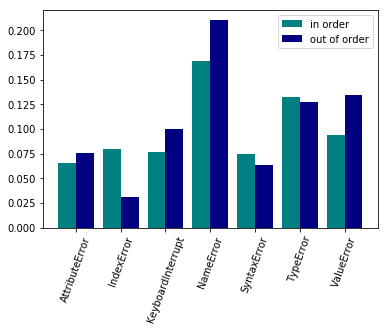

In [15]:
error_names = list(error_counts['error'][:7].values)

in_order_types = pd.Series(
    load_data.flatten(in_order.error_names)
).value_counts(normalize=True).reset_index().rename(
    columns={'index':'error',0:'proportion'}
)
in_order_types = in_order_types[in_order_types.error.isin(error_names)].sort_values(by='error')

out_order_types = pd.Series(
    load_data.flatten(out_order.error_names)
).value_counts(normalize=True).reset_index().rename(
    columns={'index':'error',0:'proportion'}
)
out_order_types = out_order_types[out_order_types.error.isin(error_names)].sort_values(by = 'error')

labels = in_order_types.error
x = np.arange(len(labels))
y1 = in_order_types.proportion
y2 = out_order_types.proportion

plt.bar(x - 0.2, y1, width = 0.4, label = 'in order', color = 'teal')
plt.bar(x + 0.2, y2, width = 0.4, label = 'out of order', color = 'navy')
plt.xticks(x, labels, rotation = 70)
plt.legend()
plt.show()

In-order notebooks have more index errors and slightly more type and syntax errors. Out of order notebooks have more name errors and value errors, and slightly more keyboard interruptions and attribute errors.

## Is number of errors associated with amount of markdown?

Add to cell order dataframe the ratio of markdown to code in each notebook.

In [16]:
cell_order_df['ratio_mc'] = [
    l.count('markdown')/l.count('code') 
    if 'code' in l else np.nan 
    for l in cell_order_df.cell_type
]

errors_mc_df = errors_df.merge(
    # ignore noteboooks without code cells (where ratio is infinity)
    cell_order_df[~cell_order_df.ratio_mc.isna()][['file','ratio_mc']], 
    on = 'file'
)

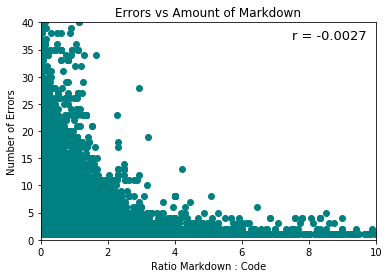

The extremely weak correlation of -0.0027 does not indicate that the number of errors is related to the amount of markdown in a notebook.


In [17]:
corr = errors_mc_df[['num_errors','ratio_mc']].corr().iloc[0,1]

plt.scatter(errors_mc_df.ratio_mc, errors_mc_df.num_errors, color = 'teal')
plt.xlabel('Ratio Markdown : Code')
plt.ylabel('Number of Errors')
plt.title('Errors vs Amount of Markdown')
plt.xlim(0, 10)
plt.ylim(0, 40)
plt.text(7.5, 37, 'r = {0}'.format(round(corr, 4)), fontsize = 13)
plt.show()

print("The extremely weak correlation of {0} does not indicate that the number of errors is related to the amount of markdown in a notebook.".format(
    round(corr,4)
))

## Are errors more or less common in educational notebooks?

Add to errors dataframe whether the notebook comes from an educational repository.

In [18]:
errors_edu_df = errors_df.merge(notebooks[['file','repo_id']], on = 'file').merge(edu_status_df, on = 'repo_id')
edu = errors_edu_df[errors_edu_df.edu == True]
not_edu = errors_edu_df[errors_edu_df.edu == False]

In [29]:
print("Among educational notebooks, there is an average of {0} errors per notebook.".format(
    round(edu.num_errors.mean(), 3)
))
print("Among non educational notebooks, there is an average of {0} errors per notebook.".format(
    round(not_edu.num_errors.mean(), 3)
))

t, p = st.mstats.ttest_ind(edu.num_errors, not_edu.num_errors)
print("T-statistic = {0}, p-value = {1}".format(round(t, 2), round(p, 2)))

Among educational notebooks, there is an average of 1.791 errors per notebook.
Among non educational notebooks, there is an average of 1.898 errors per notebook.
T-statistic = -0.85, p-value = 0.39


The number of errors is extremely close between educational notebooks and non-educational notebooks.

## Are errors more or less common in collaborative notebooks?

Add to errors dataframe the collaborative status of its repository.

In [20]:
errors_collab_df = errors_df.merge(notebooks[['file','repo_id']], on = 'file').merge(
    collab_status_df, on = 'repo_id'
)
collab = errors_collab_df[errors_collab_df.collab == 'collaborative']
watched = errors_collab_df[errors_collab_df.collab == 'watched']
isolated = errors_collab_df[errors_collab_df.collab == 'isolated']

In [21]:
print("Among collaborative notebooks, there is an average of {0} errors per notebook.".format(
    round(collab.num_errors.mean(), 2)
))
print("Among watched notebooks, there is an average of {0} errors per notebook.".format(
    round(watched.num_errors.mean(), 2)
))
print("Among isolated notebooks, there is an average of {0} errors per notebook.".format(
    round(isolated.num_errors.mean(), 2)
))

Among collaborative notebooks, there is an average of 1.77 errors per notebook.
Among watched notebooks, there is an average of 2.01 errors per notebook.
Among isolated notebooks, there is an average of 1.83 errors per notebook.


The number of errors is extremely close between the three levels of collaboration.

#### One way anova for difference in mean number of errors between collaborative, in sight, and isolated notebooks

$H_0: \mu_{collab} =  \mu_{in\_sight} = \mu_{isolate}$

$H_a$: at least one is not equal

In [22]:
F, p = st.f_oneway(collab.num_errors, watched.num_errors, isolated.num_errors)
print("F-statistic = {0}, p-value = {1}".format(
    round(F, 2), round(p, 2)
))

F-statistic = 3.29, p-value = 0.04


The one-way anova resulted in a p-value of 0.04, so there is evidence that the number of errors depends on the collaborative status of a notebook.

In [23]:
t1, p1 = st.mstats.ttest_ind(collab.num_errors, watched.num_errors)
t2, p2 = st.mstats.ttest_ind(watched.num_errors, isolated.num_errors)
t3, p3 = st.mstats.ttest_ind(collab.num_errors, isolated.num_errors)
print('None of the pairwise p-values are significant: {0}, {1}, {2}.'.format(
    round(p1,2), round(p2,2), round(p3,2)
))

None of the pairwise p-values are significant: 0.06, 0.07, 0.09.


## Are errors more or less likely to occur in notebooks using machine learning frameworks?

Add framework use information to DataFrame.

In [24]:
non_ml_files = errors_df[[
    row['sklearn'] + row['tensorflow'] + row['keras'] == 0 
    for _, row in errors_df.iterrows()
]]
ml_files = errors_df[~errors_df.file.isin(non_ml_files.file)]
print("Among notebooks using machine learning, there is an average of {0} errors per notebook.".format(
    round(ml_files.num_errors.mean(), 2)
))
print("Among notebooks not using machine learing, there is an average of {0} errors per notebook.".format(
    round(non_ml_files.num_errors.mean(), 2)
))

Among notebooks using machine learning, there is an average of 1.66 errors per notebook.
Among notebooks not using machine learing, there is an average of 1.87 errors per notebook.


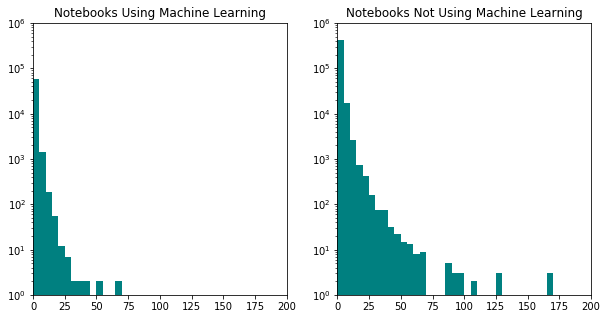

In [25]:
fig = plt.figure(figsize = (10,5))

plt.subplot(1,2,1)
plt.title('Notebooks Using Machine Learning')
plt.yscale('log')
plt.ylim(1, 1000000)
plt.xlim(0, 200)
plt.hist(ml_files.num_errors, bins = range(0,200,5), color = 'teal')

plt.subplot(1,2,2)
plt.title('Notebooks Not Using Machine Learning')
plt.yscale('log')
plt.ylim(1, 1000000)
plt.xlim(0, 200)
plt.hist(non_ml_files.num_errors, bins = range(0,200,5), color = 'teal')

plt.show()

Both groups of notebooks number of errors concentrated at 0 and both distributions are skewed right. The number of errors for notebooks not using machine learning has a slightly wider range.

#### Two sample t test for difference in mean number of errors between notebooks using and not using machine learning frameworks.

$H_0$: $µ_{ml}$ = $µ_{not ml}$

$H_0$: $µ_{ml}$ ≠ $µ_{not ml}$

Where $µ_{ml}$ is the average number of errors in a notebook using at least one of the tree machine learning frameworks, $µ_{not ml}$ is the average number of errors in a notebook *not* using any of the three machine learning frameworks.

In [26]:
n_ml = len(ml_files)
xbar_ml = pd.Series(ml_files.num_errors).mean()
s2_ml = pd.Series(ml_files.num_errors).var()

n_notml = len(non_ml_files)
xbar_notml = pd.Series(non_ml_files.num_errors).mean()
s2_notml = pd.Series(non_ml_files.num_errors).var()

df = n_ml + n_notml - 2

se = math.sqrt(s2_ml/n_ml + s2_notml/n_notml)
t = (xbar_ml - xbar_notml) / se
p_value = 2*st.t.cdf(t, df)

print("T-statistic:", round(t,2))
print("P-value:", round(p_value,2))

T-statistic: -1.34
P-value: 0.18


The p-value of 0.18 does not provide enough evidence to reject the null hypothesis, so we cannot conclude that the mean number of errors is different in notebooks using at least one of the three main machine learning frameworks (tensorflow, keras, sklearn) than in notebooks using none.

[Visualizations &lt;](9_Visualizations.ipynb) | [&gt; API Design](11_APIs.ipynb)